# Chaotic Advection and Blinking Vortices

In this notebook we investigate the behavior of two vortices in a fluidic system and how this system evolves chaotically given that these vortices blink. I.e. when the sign of the vortices change discretly over time.

## Construction of Ordinary Differential Equations

The equation for the dipole system can be framed in terms of the velocity vector where we denote:

$$\boldsymbol{u} = (u,v)$$

With the scalar $u$ and $v$ functions given by:

$$u(x,y) = \frac{- \alpha y}{\left(x-\beta\right)^2 + y^2} - \frac{\alpha y}{\left(x+\beta\right)^2 + y^2}$$

$$v(x,y) = \frac{\alpha \left(x-\beta\right)}{\left(x-\beta\right)^2 + y^2} + \frac{\alpha \left(x+\beta\right)}{\left(x+\beta\right)^2 + y^2}$$

To solve for the position vector:

$$\boldsymbol{x} = (x,y)$$

One would simply integrate over $\boldsymbol{u}$ as such:

$$\frac{d\boldsymbol{x}}{dt} = \boldsymbol{u}$$

## Integration with Non-Blinking Vortices

To integrate the equations without blinking vortices, we assume that the fluid is in steady state. That is, there is no explicit time dependence in the above ODEs. Such assumptions will change when we include blinking vortices.

To complete the integration in python, we use SciPy's odeint as well as a custom function and thus will need to import alongside NumPy etc.

In [1]:
from scipy.integrate import odeint
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from suppress_out import stdout_redirected
import warnings

Below is a function which allows for the calculation of velocities in the steady state.

In [2]:
def calculateVelocities(x,y,alpha,beta):
    u = (- alpha * y)/((x-beta)**2 + y**2) - (alpha * y)/((x+beta)**2 + y**2)
    v = (alpha * (x-beta))/((x-beta)**2 + y**2) + (alpha * (x+beta))/((x+beta)**2 + y**2)
    
    return u,v

Below we define the model for ODE solving which can be used by both scipy and the custom ODE solver that we build for assesment of numerical errors.

In [3]:
# We define the steady state ODEs with parameters alpha and beta
def steadyStateODEs(diff_array,t,alpha,beta):
    x = diff_array[0]
    y = diff_array[1]
    
    # These equations are as above
    u = (- alpha * y)/((x-beta)**2 + y**2) - (alpha * y)/((x+beta)**2 + y**2)
    v = (alpha * (x-beta))/((x-beta)**2 + y**2) + (alpha * (x+beta))/((x+beta)**2 + y**2)
    
    return np.array([u, v])

Below we define our time space to be of 10 seconds, with 100 points per second. This will give a fairly accurate numerical simulation. However, as we decrease the number of points, the simulation will no longer remain as accurate.

In [4]:
t = np.linspace(0,10,1000)

## Construction of Custom ODE Solver

For our own ODE solver, we use the Runge-Kutta 4th Order method as this provides better numerical accuracy than that of forward differences. We also compare it in later sections wtih the odeint() function to see whether the latter should be used in calculation of the Lyupanov exponent.

In [5]:
def rungeStep(ODE, t0, y0, h,args):
    k1 = h*ODE(y0, t0, args[0], args[1])
    k2 = h*ODE(y0 + 0.5*k1, t0 + 0.5*h, args[0], args[1])
    k3 = h*ODE(y0 + 0.5*k2, t0 + 0.5*h, args[0], args[1])
    k4 = h*ODE(y0 + k3, t0 + h, args[0], args[1])
        
    y = y0 + (1/6)*(k1+2*k2+2*k3+k4);
    t = t0 + h
    return y

In [6]:
def rungeSolve(ODE, y0,t, args):
    loc = np.array([y0])
    alpha = args
    
    for i,timeStep in enumerate(t):
        loc1=rungeStep(ODE, timeStep, loc[-1], t[1]-t[0], args)
        loc=np.vstack((loc,loc1))
        
    return loc

## Demonstrating Circular Paths with Specific Points

By integration of these ODEs we may show that given an initial particle position, paths follow regular orbits in the flow field. Namely, that if we plot the $x$ and $y$ vlaues, we should get paths which appear to orbit around a central point. To demonstrate this, we choose a set of 4 random positions in each of the four quadrants of the cartesian plane. To see if there is a significant difference between the Runge and SciPy results for the time space defined, we plot the Runge on top of the ODE.

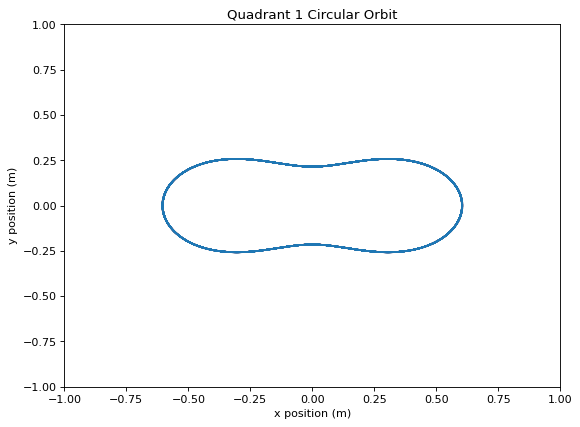

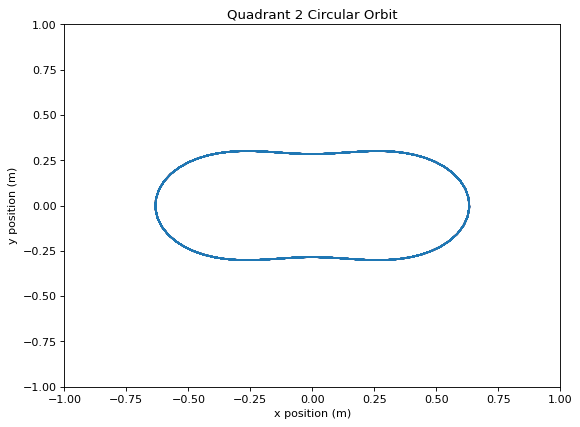

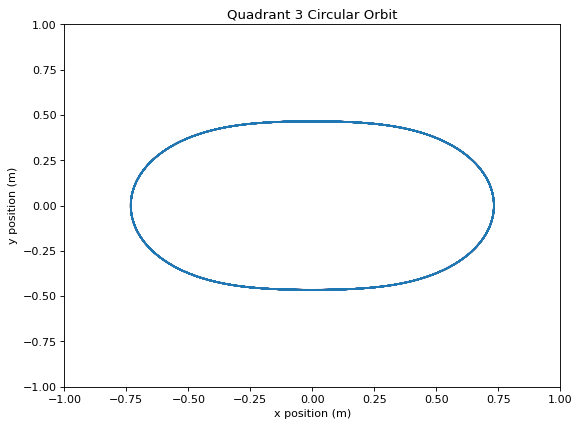

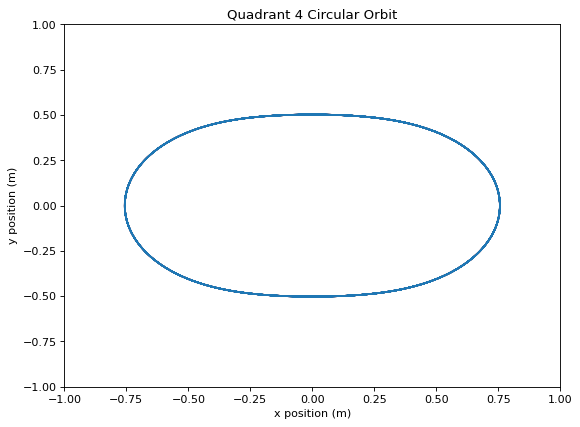

In [7]:
initialPositionQs = [[0.5,0.2], [-0.3,0.3], [-0.6,-0.3], [0.1,-0.5]]
quadrantResultsRunge = []
quadrantResultsODEInt = []

for initialPosition in initialPositionQs:
    quadrantResultsRunge.append(rungeSolve(steadyStateODEs, initialPosition, t, args=(1,0.4)))
    quadrantResultsODEInt.append(odeint(steadyStateODEs, initialPosition, t, args=(1,0.4)))

for i, quadrantResult in enumerate(quadrantResultsRunge):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(quadrantResultsODEInt[i][:,0], quadrantResultsODEInt[i][:,1], c='salmon')
    plt.plot(quadrantResult[:,0], quadrantResult[:,1])
    plt.title(f"Quadrant {i+1} Circular Orbit")
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("x position (m)")
    plt.ylabel("y position (m)")
    plt.show()

As we can see there are clearly obrital paths and the SciPy results are not distinguishable from the Runge method. However, these plots only consider paths in a small region around the centre of the field and thus miss much of the possible behaviour. As such, we wish to plot the vector field itself to see the motion more clearly.

## Plotting Vector Field and Trajectories

We wish to plot the vector field of the ODEs in order to get a better sense of the circular orbits which the particles take. We do so by iterating over a mesh grid of initial $x$ and $y$ positions to get the velocity vectors and then plotting some paths as well. To do so, we use the function written to find the velocities and then employ the streamplot implementation in matplotlib.

We also plot the above trajectories to better visualise their placement in the field.

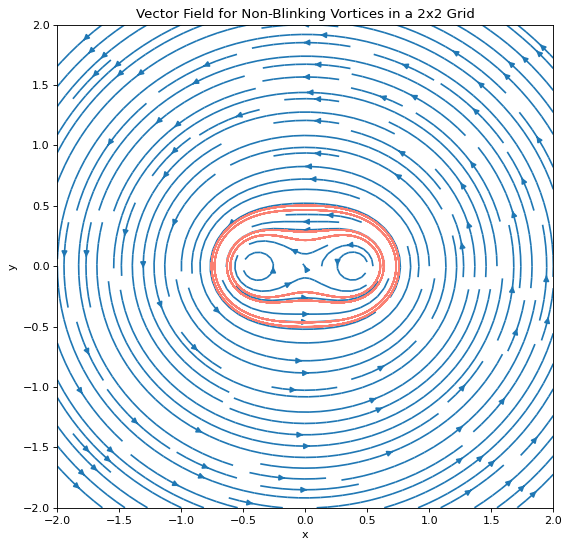

In [8]:
y = np.linspace(-2,2,500)
x = np.linspace(-2,2,500)
X,Y = np.meshgrid(x,y)

u,v = calculateVelocities(X,Y,1,0.4)

plt.figure(figsize=(8,8), dpi=80)
plt.streamplot(x,y,u,v,density=1.5)
plt.xlim([-2, 2])
plt.ylim([-2,2])
plt.title("Vector Field for Non-Blinking Vortices in a 2x2 Grid")
plt.xlabel('x')
plt.ylabel('y')

for i, quadrantResult in enumerate(quadrantResultsRunge):
    plt.plot(quadrantResult[:,0], quadrantResult[:,1], c='salmon')

plt.show()

As we can see paths are within the most complicated area of the field. That is, near the two vortices.

## Investigation of Numerical Accuracy

We might want to characterise how changes in timestep alter the accuracy of results. Since we assume incompressible flow, we can do so by noting that streamlines are parallel with contours of streamfunctions and can thus compare the fidelity of the paths we find via integration to these streamfunctions. Where we know that the streamfunction $\phi$ is given by:

$$v = \frac{\partial \phi}{\partial x}$$

Hence, we can integrate analytically:

$$\phi = \int v dx = \frac{1}{2} \alpha \ln(x^4 + 2 x^2 (y - \beta) (y + \beta) + (y^2 + \beta^2)^2)$$

## Contour Plot of Streamline Function

We plot the contour plot for the streamline function below.

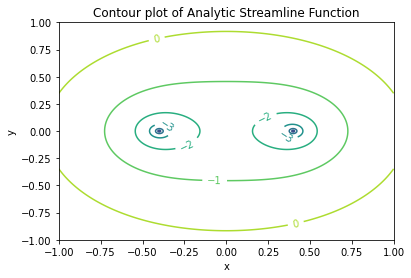

In [9]:
alpha = 1
beta = 0.4

x = np.linspace(-1,1,1000)
y = np.linspace(-1,1,1000)

X,Y = np.meshgrid(x,y)

Z = (1/2) * alpha * np.log(X**4 + (2*X**2)*(Y-beta)*(Y+beta) + (Y**2 + beta**2)**2)

fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
plt.title("Contour plot of Analytic Streamline Function")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

## Visual Numerical Accuracy Comparison with Analytic Streamlines

We define an array of different time steps over a length of 5 seconds in order to get a good sense of how the accuracy decreases visually and numerically.  

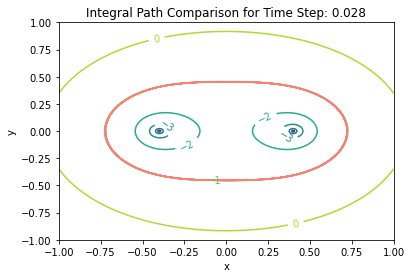

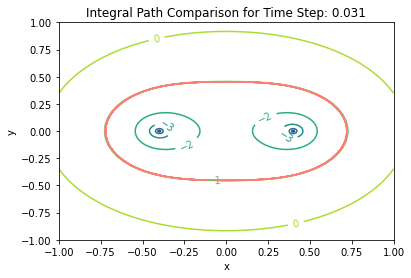

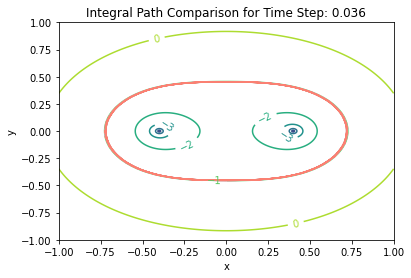

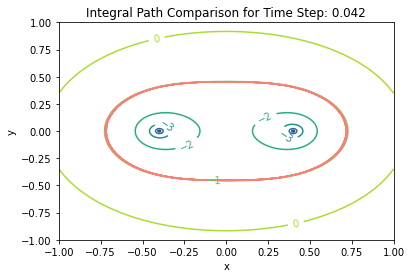

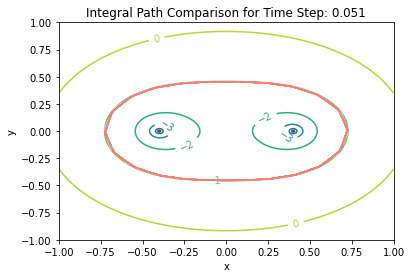

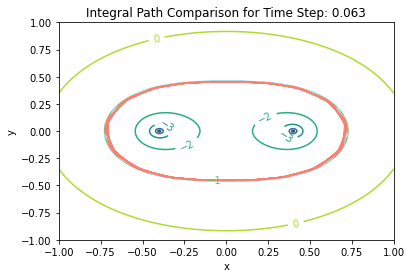

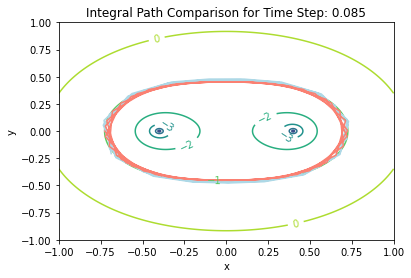

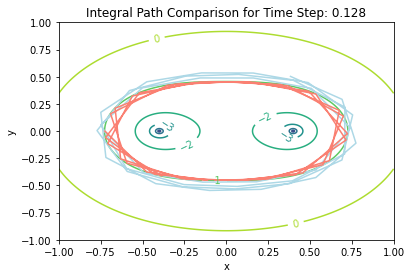

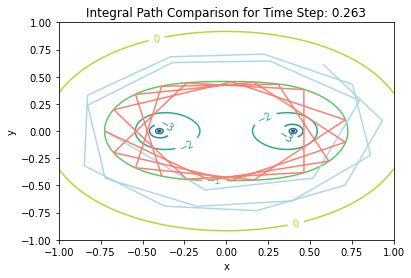

In [10]:
timeStepList = []
timeStepAxis = []

for i in range(1,10):
    timeStepList.append(np.linspace(0,5,(i)*20))
    timeStepAxis.append(1/((i)*20))

timeStepList.reverse()
timeStepAxis.reverse()
    
rungePaths = []
odeIntPaths = []

for t in timeStepList:
    rungePaths.append(rungeSolve(steadyStateODEs, [-0.725,0], t, args=(1,0.4)))
    odeIntPaths.append(odeint(steadyStateODEs, [-0.725,0], t, args=(1,0.4)))

for i in range(len(rungePaths)):
    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=True, fontsize=10)
    plt.title(f"Integral Path Comparison for Time Step: {round(timeStepList[i][1] - timeStepList[i][0], 3)}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.plot(rungePaths[i][:,0], rungePaths[i][:,1], c='lightblue')
    plt.plot(odeIntPaths[i][:,0], odeIntPaths[i][:,1], c='salmon')

At least visually, it appears that the Runge and SciPy methods have quite similar numerical accuracy for sufficiently low time steps. However, as the time steps become larger, the SciPy function appears to be more accurate.

## Numerical Error Between Analytic, Runge and SciPy

We compare the numerical error by considering the final location of each path after 5 second and determine how far this deviates from the correct path as indicated by the contours of the streamline function. For this particular application we take the contour given by:

$$1 = \frac{1}{2} \alpha \ln(x^4 + 2 x^2 (y - \beta) (y + \beta) + (y^2 + \beta^2)^2)$$

Where we calculate the true endpoint via integration to be approximately $(-0.38547, -0.41197)$ which lies very close to the above contour.

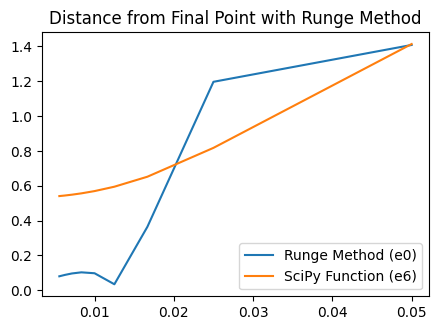

In [11]:
(xf,yf) = (-0.38547, -0.41197)

distanceToPointRunge = []
distanceToPointODEInt = []

for i in range(len(rungePaths)):
    distanceToPointRunge.append(((xf - rungePaths[i][-1][0])**2 + (yf - rungePaths[i][-1][1])**2)**(1/2))
    distanceToPointODEInt.append(((xf - odeIntPaths[i][-1][0])**2 + (yf - odeIntPaths[i][-1][1])**2)**(1/2))

figure = plt.figure(figsize=(5,3.5), dpi=100)
plt.title("Distance from Final Point with Runge Method")
plt.plot(timeStepAxis,distanceToPointRunge, label='Runge Method (e0)')
plt.plot(timeStepAxis, np.multiply(10e5,distanceToPointODEInt), label='SciPy Function (e6)')
plt.legend()
plt.show()

As can be seen, SciPy's integration function is more accurate than that of the Runge method so we use it for the calculation of Lyupanov exponents. However, as can be seen visually, the smooth trend of the SciPy formulation may not be representative of the full accuracy as the solution tends to "return" to the contour periodically.

## Tangible Orbit Differences with Changing Time Step

To further investigate the true accuracy of SciPy, we graph an orbit close to the centre of the field.

In [12]:
def plotSecondQuadrantPath(iterations, temporalLength):
    t = np.linspace(0,temporalLength,iterations)
    path = odeint(steadyStateODEs, [-0.2,0.2], t, args=(1,0.4))
    timeStep = temporalLength/iterations
    
    fig = plt.figure(figsize=(4, 3), dpi=80)
    plt.plot(path[:,0], path[:,1])
    plt.title(f"Quadrant 2 Circular Orbit with timestep {timeStep}")
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("x position (m)")
    plt.ylabel("y position (m)")
    plt.show()

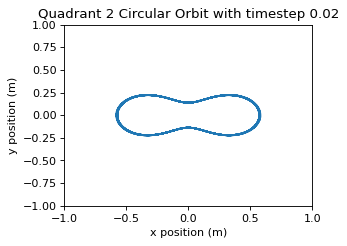

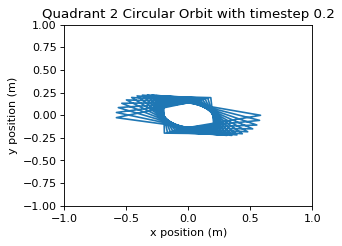

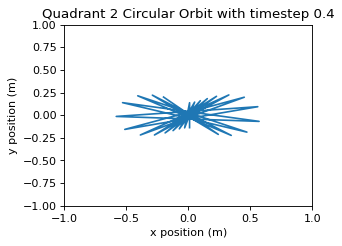

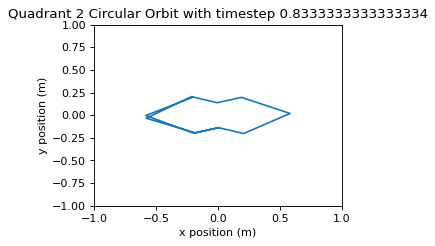

/Users/jackmiller/miniforgeRosetta/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


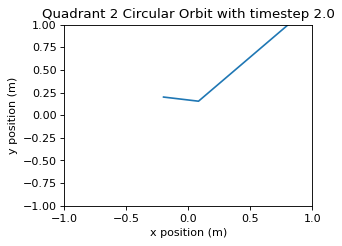

In [13]:
iterationNumbers = [500,50,25,12,5]
    
for iterationNumber in iterationNumbers:
    plotSecondQuadrantPath(iterationNumber,10)

As we can see as the time step increases, the accuracy of results appears to go down. This is because the ODE solver recursively calculates the next position by using that of the previous. I.e. the solver is memoryless. The new position is entirely based on the old, and the temporal distance between these points is given by the timestep. If the step is large, one does not stay on a singular path, rather, varying between many distinct paths in the vector field.

While we may say it can be more accurate than the Runge method, it still presents problems with numerical accuracy. As such, we need to use small time steps for modeling.

## Blinking Vortices

In order to implement the equations for blinking vortices we add time dependence to the beta parameter in our equations and remove the secondary terms. As such they appear:

$$u(x,y,t) = \frac{- \alpha y}{\left(x-\beta\right)^2 + y^2}$$

$$v(x,y,t) = \frac{\alpha \left(x-\beta\right)}{\left(x-\beta\right)^2 + y^2}$$

$$\beta(t) = \beta_0 \text{sign}\left(\sin(2 \pi t)\right)$$

This beta term acts to alternatively turn the left and right vortices off and on.

In [17]:
# We define the time depdent ODEs with the parameters alpha and alpha_0
def chaoticODEs(diff_array,t,alpha,beta_0):
    x = diff_array[0]
    y = diff_array[1]
    
    # Inclusion of time dependent beta
    beta = beta_0 * np.sign(np.sin(2*np.pi*t))
    
    # These equations are as above
    u = (- alpha * y)/((x-beta)**2 + y**2)
    v = (alpha * (x-beta))/((x-beta)**2 + y**2)
    
    return [u, v]

We now solve this equation for the initial conditions of the quadrant 2 orbital path to get an indication as to behaviour.

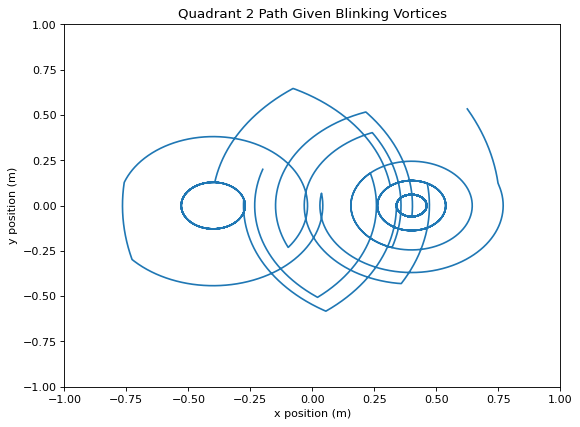

In [18]:
t = np.linspace(0,10,10000)

path = odeint(chaoticODEs, [-0.2,0.2], t, args=(1,0.4))

fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(path[:,0], path[:,1])
plt.title("Quadrant 2 Path Given Blinking Vortices")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("x position (m)")
plt.ylabel("y position (m)")
plt.show()

As can be seen, there are two attractors in the system, and the parcel appears to alternate between them.

## Ploting Vector Field for Different States

We plot the vector field from the two different states of the system. That is, each vortex either on or off.

In [41]:
def calculateVelocitiesBlinking(x,y,t,alpha,beta_0):
    beta = beta_0 * np.sign(np.sin(2*np.pi*t))
    
    u = (- alpha * y)/((x-beta)**2 + y**2)
    v = (alpha * (x-beta))/((x-beta)**2 + y**2)
    
    return u,v

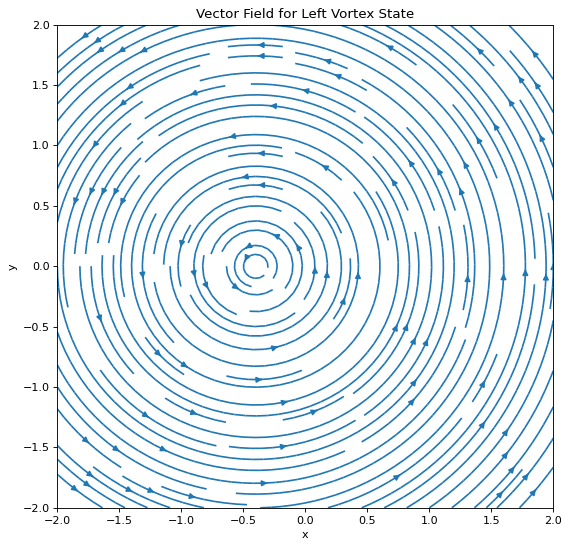

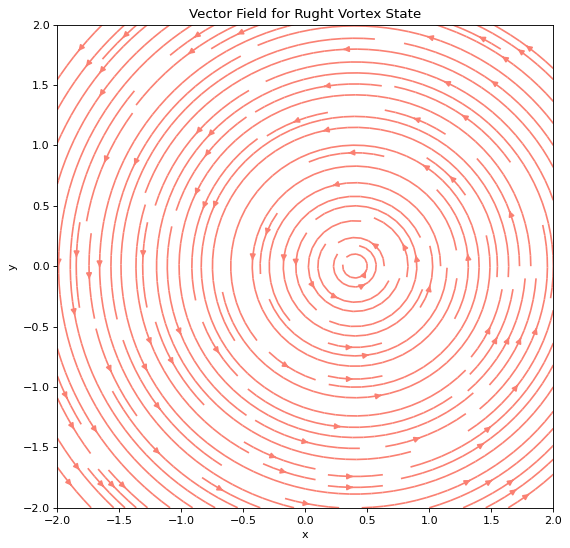

In [42]:
y = np.linspace(-2,2,500)
x = np.linspace(-2,2,500)
X,Y = np.meshgrid(x,y)

u1,v1 = calculateVelocitiesBlinking(X,Y,1,1,0.4)
u2,v2 = calculateVelocitiesBlinking(X,Y,2*math.pi,1,0.4)

plt.figure(figsize=(8,8), dpi=80)
plt.streamplot(x,y,u1,v1,density=1.5)
plt.xlim([-2, 2])
plt.ylim([-2,2])
plt.title("Vector Field for Left Vortex State")
plt.xlabel('x')
plt.ylabel('y')

plt.show()

plt.figure(figsize=(8,8), dpi=80)
plt.streamplot(x,y,u2,v2,density=1.5, color='salmon')
plt.xlim([-2, 2])
plt.ylim([-2,2])
plt.title("Vector Field for Rught Vortex State")
plt.xlabel('x')
plt.ylabel('y')

plt.show()

## Calculation of Lyapunov Exponents

We compute the Laypunov exponents using Wolf's algorithm, where we generate our trajectory points using the ODE integration method used above. In Wolf's algorithm:
1. We choose two points that are close together (that is $d_0$ close)
2. Track the distance between them over a fixed time ($\Delta t$)
3. Once a certain time has passed, we renormalise by tracking the trajectory from $d_0$ again
4. We complete this process $M$ times

The exponent is thus given by:

$$\lambda = \frac{1}{\Delta t} \sum_{i=0}^{M-1} \ln \frac{L_i'}{d_0}$$

Where $L_i$ is the distance between the trajectories after the time $\Delta t$.

Note here that we don't choose the point $d_0$ away so that it maximises the expansion. While this choice may seem necessary to find the maximal Lyapunov exponent, instead running Wolf's algorithm many times selects for this maximal expansion. This is because as you are choosing a random direction initially and this direction will have components in the maximal direction. Hence, such components will grow the largest over the trajectory and when you renormalise $d_0$ without changing the direction, you have a greater weighting towards these.

## Defining the Phase Space

We know that, "The phase space is given by the set of variables needed to specify the system." Since the vortices blink, the system is specified by the time, $\alpha$ and $\beta_0$. However, we keep the latter two parameters at the same values of $1$ and $0.4$ so will take the phase space to be that of the temporal dimension.

If one examines the paper Dynamics of Blinking Vortices by Daitche and Tél (2009) (https://www.researchgate.net/publication/24173470_Dynamics_of_blinking_vortices), they use Wolf's algorithm for calculation of the maximal exponent but find that it decays with time. As such, we attempt the same approach and see if we achieve the same results.

In [43]:
# In this function we define a single iteration of the algorithm which
# we, in another function, may apply M times
def wolfIteration(point1, point2, t0, tdelta, iterations):
    
    # Gets the initial points
    (x1,y1) = point1
    (x2,y2) = point2
    
    # Defines the time array
    t = np.linspace(t0,tdelta+t0,iterations)
    
    # Calculates the paths over that time array
    path1 = odeint(chaoticODEs, [x1,y1], t, args=(1,0.4))
    path2 = odeint(chaoticODEs, [x2,y2], t, args=(1,0.4))
    
    (foX, foY) = (path1[:,0][iterations-1],path1[:,1][iterations-1])
    (fpX,fpY) = (path2[:,0][iterations-1],path2[:,1][iterations-1])
    
    distance = np.sqrt((path1[:,0][iterations-1] - path2[:,0][iterations-1]) ** 2 \
                   + (path1[:,1][iterations-1] - path2[:,1][iterations-1]) ** 2)
    
    return distance, (foX, foY), (fpX,fpY)

## Choosing the Magnitude and Direction of $\overrightarrow{\boldsymbol{d_0}}$

In this context we take $\overrightarrow{\boldsymbol{d_0}}$ to be a vector defining the direction between the starting point and the close point of interest for every iteration. We choose this vector after each iteration by taking the difference between the end point of the two trajectories and scaling down to a size given by the scalar $d_0$. This appears (where $n$ is the $n^{th}$ path):

$$\overrightarrow{\boldsymbol{d_0}}(t) = \overrightarrow{x(t)} + \frac{d_0}{L} \left(x(t) - x_{n-1} (t)\right)$$

(The same methodology can be seen in Daitche and Tél)

In [44]:
def d0Point(point1, prevTrajPoint, d0, L):
    (x1,y1) = point1
    (x2,y2) = prevTrajPoint 
    x = x1 + (d0 / L) * (x2 - x1)
    y = y1 + (d0 / L) * (y2 - y1)
    
    return (x,y)

In [79]:
def calculateMaximalLyapunov(originalPoint, neighbourPoint, lIterations, params):
    (x0, y0) = originalPoint
    (x1,y1) = neighbourPoint
    tDelta = params['tDelta']
    iterations = params['iterations']
    d0 = params['d0']
    
    lyapunovSum = 0
    
    cm = []
    pts = []
    
    for lIteration in range(lIterations):
        
        if (lIteration == 0):
            distance, (foX, foY), (fpX,fpY) = wolfIteration(originalPoint, neighbourPoint, 0, \
                                                           tDelta, iterations)
        else:
            distance, (foX, foY), (fpX,fpY) = wolfIteration((foX, foY), d0Vec, lIteration*tDelta, \
                                                               tDelta, iterations)
                
        d0Vec = d0Point((foX, foY), (fpX,fpY), d0, distance)
        lyapunovSum += np.log(distance/d0)
        
        if vlIteration % 50 == 0:
            pts.append((foX,foY))
        
        if lIteration % 100 == 0 and lIteration != 0:
            cm.append(lyapunovSum / (tDelta * lIteration))
    
    return (lyapunovSum / (tDelta * lIterations)), cm, pts

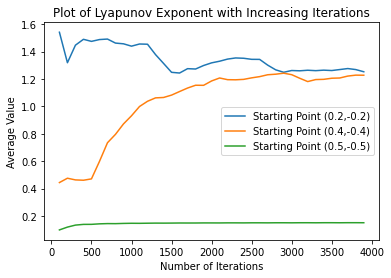

In [77]:
# We define some constants for the running of the Wolf algorithm
params = {
    'tDelta': 0.5,
    'iterations': 4000,
    'd0': 0.01
}

finalExp1, cm1, pts1 = calculateMaximalLyapunov((0.2,-0.2),(0.21,-0.2),4000,params)
finalExp2, cm2, pts2 = calculateMaximalLyapunov((0.4,-0.4),(0.41,-0.4),4000,params)
finalExp3, cm3, pts3 = calculateMaximalLyapunov((0.5,-0.5),(0.51,-0.5),4000,params)

iterationSpace = np.linspace(100,3900,39)

fig = plt.figure()

plt.plot(iterationSpace, cm1, label='Starting Point (0.2,-0.2)')
plt.plot(iterationSpace,cm2, label='Starting Point (0.4,-0.4)')
plt.plot(iterationSpace,cm3, label='Starting Point (0.5,-0.5)')
plt.title("Plot of Lyapunov Exponent with Increasing Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Average Value")
plt.legend()
plt.show()

As we can see, the Lyapunov exponent appears to decrease with the number of iterations and then reach a steady state. A possible cause could be the particle leaving the chaotic region of the system which we may guess to be the centre. To confirm or deny this hypothesis we graph the set of positions in which Wolf's algorithm is reapplied.

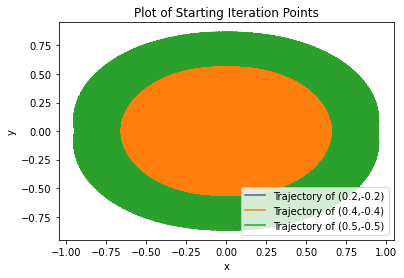

In [78]:
fig = plt.figure()

plt.plot(*zip(*pts1), label='Trajectory of (0.2,-0.2)')
plt.plot(*zip(*pts2), label='Trajectory of (0.4,-0.4)')
plt.plot(*zip(*pts3), label='Trajectory of (0.5,-0.5)')
plt.title("Plot of Starting Iteration Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()